# <NLP 모델링>

# LDA 모델

### 함수 정의

In [109]:
def clean_datetime(date_col):
    from datetime import datetime

    date_col = date_col.apply(lambda x: datetime.strptime(datetime.strftime(x, format="%Y-%m-%d"), "%Y-%m-%d"))
    return date_col

In [110]:
#Corpus 만드는 함수
def make_corpus(text_col):
    from gensim import corpora
    dictionary = corpora.Dictionary(text_col)
    corpus = [dictionary.doc2bow(text) for text in text_col]
    return dictionary, corpus

In [111]:
#LDA 모델 훈련시키는 함수
def make_LDA(corpus, dictionary, num_topics, num_words):
    import gensim
    NUM_TOPICS = num_topics
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words = num_words)

    return ldamodel, topics

In [112]:
#각 기사의 Topic 비중을 나타내는 dataframe을 생성하는 함수
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame(columns = [str(x) for x in range(ldamodel.num_topics)])

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            

        # 모든 문서에 대해서 각각 아래를 수행
        dict_topic_list = {}
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            dict_topic_list[str(topic_num)] = prop_topic
        
        series_topic_list = pd.Series(dict_topic_list)
        topic_table = topic_table.append(dict_topic_list, ignore_index=True)
        
    return(topic_table)

In [113]:
#기존 covid 뉴스 dataframe과 Topic 정보를 나타내는 dataframe을 합치는 함수
def covid_concat(origin_df, topic_table):
    covid_topic= pd.concat([origin_df, topic_table], axis=1)
    return covid_topic

In [114]:
#각 날짜에 해당하는 모든 기사 Topic 정보 합치는 함수
def grouped_by_date(concat_df, num_topics):
    grouped_df = concat_df[[str(x) for x in range(num_topics)]].groupby(concat_df['게시날짜'])
    grouped_with_sum = grouped_df.sum()
    grouped_with_sum['합계'] = grouped_with_sum.sum(axis=1)
    return grouped_with_sum

In [115]:
def normalized_topic(topic_sum_df):
    for i in range(len(topic_sum_df)):
        topic_sum_df.iloc[i] = topic_sum_df.iloc[i] / topic_sum_df.iloc[i, -1]
    return topic_sum_df

### 실행

In [116]:
covid = pd.read_pickle('./data_processed/A.News_preprocessed/covid_ready_for_LDA.pkl')
covid.head(10)

,파일명,제목,URL,수집일자,게시날짜,채널명,감염병명,분류명,기사내용
0,ALJA2020011600003,China says Wuhan disease outbreak may be new c...,https://www.aljazeera.com/news/2020/01/chinese...,2020-01-16 13:00:06.0,2020-01-09,Al jazeera,COVID-19,Viral,"[authority, strain, caused, current, epidemic,..."
1,CIDA2020011600007,China to share with WHO new-type coronavirus' ...,http://en.nhc.gov.cn/2020-01/12/c_75969.htm,2020-01-16 16:00:28.0,2020-01-12,CIDARS (China Infectious Disease Automated Ale...,COVID-19,Viral,"[BEIJING, china, share, world, organization, W..."
2,CBCH2020011600020,Woman with new coronavirus quarantined in Thai...,https://www.cbc.ca/news/health/coronavirus-tha...,2020-01-16 13:22:35.0,2020-01-13,CBC,COVID-19,Viral,"[chinese, woman, quarantine, thailand, mystery..."
3,MEDI2020011900081,Indian school teacher in Shenzhen becomes firs...,https://medisys.newsbrief.eu/medisys/helsinkie...,2020-01-19 23:00:11.0,2020-01-13,MediSys,COVID-19,Viral,"[disease, glanders, location, turkey, horse, d..."
4,WHOD2020011800001,Novel Coronavirus – Thailand (ex-China),https://www.who.int/csr/don/14-january-2020-no...,2020-01-18 04:00:07.0,2020-01-14,WHO/DONs,COVID-19,Viral,"[ministry, labour, welfare, japan, MHLW, impor..."
5,ECDC2020011500001,Update: Cluster of pneumonia cases associated ...,https://www.ecdc.europa.eu/en/news-events/upda...,2020-01-16 15:00:17.0,2020-01-14,ECDC,COVID-19,Viral,"[onset, symptom, range, december, transmission..."
6,CBCH2020011600009,'Possible' there was limited human-to-human tr...,https://www.cbc.ca/news/health/china-virus-who...,2020-01-16 13:22:19.0,2020-01-14,CBC,COVID-19,Viral,"[limited, transmission, china, within, family,..."
7,GPHN2020011600036,China says human transmission not ruled out in...,https://gphin.canada.ca/cepr/showarticle.jsp?d...,2020-01-16 01:05:15.0,2020-01-15,GPHIN,COVID-19,Viral,"[fear, mount, across, asia, spread, identify, ..."
8,GPHN2020011600070,China coronavirus outbreak: five members of tw...,https://gphin.canada.ca/cepr/showarticle.jsp?d...,2020-01-16 04:01:53.0,2020-01-15,GPHIN,COVID-19,Viral,"[northern, KENTUCKY, experiencing, increase, w..."
9,GPHN2020011600028,US warns citizens in China against pneumonia o...,https://gphin.canada.ca/cepr/showarticle.jsp?d...,2020-01-16 01:04:14.0,2020-01-15,GPHIN,COVID-19,Viral,"[china, nji, vietnam, celebrate, nguy, feast, ..."


In [117]:
##num_topics, num_words 정하기
Num_Topics = 8
Num_Words = 10

In [118]:
##def 실행 - dictionary와 corpus 생성 , ldamodel, topic 생성
np.random.seed(100)
dictionary, corpus = make_corpus(covid['기사내용'])
ldamodel, topics = make_LDA(corpus, dictionary, Num_Topics, Num_Words)

In [119]:
####LDA모델이 잘 만들어졌는지 확인
for topic in tqdm(topics):
    print('{}번째 Topic'.format(topic[0]), topic[1])

100%|██████████| 8/8 [00:00<00:00, 9061.42it/s]

0번째 Topic 0.020*"death" + 0.012*"confirm" + 0.011*"ministry" + 0.010*"test" + 0.010*"minister" + 0.009*"government" + 0.008*"positive" + 0.008*"infection" + 0.007*"italy" + 0.007*"virus"
1번째 Topic 0.019*"virus" + 0.012*"death" + 0.009*"world" + 0.008*"outbreak" + 0.008*"spread" + 0.007*"pandemic" + 0.006*"WHO" + 0.006*"disease" + 0.005*"data" + 0.005*"rate"
2번째 Topic 0.061*"VIRGINIA" + 0.031*"test" + 0.022*"trump" + 0.017*"NEWYORK" + 0.016*"death" + 0.016*"US" + 0.010*"WASHINGTON" + 0.010*"american" + 0.009*"center" + 0.009*"CDC"
3번째 Topic 0.077*"china" + 0.031*"chinese" + 0.023*"wuhan" + 0.019*"province" + 0.013*"patient" + 0.013*"confirm" + 0.012*"hospital" + 0.011*"medical" + 0.009*"hubei" + 0.009*"outbreak"
4번째 Topic 0.020*"patient" + 0.012*"disease" + 0.010*"drug" + 0.010*"SARS" + 0.010*"study" + 0.009*"covV" + 0.009*"test" + 0.008*"vaccine" + 0.008*"virus" + 0.008*"infection"
5번째 Topic 0.018*"test" + 0.014*"hospital" + 0.013*"care" + 0.013*"patient" + 0.012*"home" + 0.008*"positi

In [120]:
covid.reset_index(inplace=True)

In [121]:
##def 실행 - 각 기사별로 topic 비중 확인하기
topictable = make_topictable_per_doc(ldamodel, corpus)
covid_topic_df = covid_concat(covid['게시날짜'], topictable)

In [122]:
####covid_topic 잘 만들어졌는지 확인
covid_topic_df.head()

,게시날짜,0,1,2,3,4,5,6,7
0,2020-01-09,NaN,0.365620,NaN,0.359472,0.269108,NaN,NaN,NaN
1,2020-01-12,NaN,NaN,NaN,0.417159,0.218018,NaN,0.337626,NaN
2,2020-01-13,0.046260,0.358464,NaN,0.426247,0.108301,NaN,0.058238,NaN
3,2020-01-13,0.361788,NaN,0.086853,0.109916,0.241738,0.037697,NaN,0.154846
4,2020-01-14,NaN,NaN,NaN,0.408017,0.391577,0.177279,0.021193,NaN


In [123]:
covid_topic_df['게시날짜'] = clean_datetime(covid_topic_df['게시날짜'])

##def 실행 - 날짜 기준으로 기사의 topic 정보 합침
grouped_with_sum = grouped_by_date(covid_topic_df, Num_Topics)

In [124]:
####grouped_with_sum 잘 만들어졌는지 확인
grouped_with_sum

,0,1,2,3,4,5,6,7,합계
게시날짜,,,,,,,,,
2020-01-09,0.000000,0.365620,0.000000,0.359472,0.269108,0.000000,0.000000,0.000000,0.994199
2020-01-12,0.000000,0.000000,0.000000,0.417159,0.218018,0.000000,0.337626,0.000000,0.972803
2020-01-13,0.408049,0.358464,0.086853,0.536164,0.350039,0.037697,0.058238,0.154846,1.990349
2020-01-14,0.171830,0.589587,0.000000,1.126933,0.810938,0.224129,0.068795,0.000000,2.992212
2020-01-15,2.646131,8.777371,0.800937,11.481286,13.543593,9.511173,2.217261,1.688445,50.666198
...,...,...,...,...,...,...,...,...,...
2020-05-02,75.276617,50.083537,19.875043,34.488928,43.372378,65.056942,30.037551,60.944209,379.135204
2020-05-03,83.420959,49.649956,28.348240,23.031755,32.858635,63.668643,25.356868,70.576088,376.911146
2020-05-04,123.309935,82.845190,25.291176,32.049030,68.431574,102.363167,62.501749,161.421111,658.212933


In [125]:
##def 실행 - normalizing
covid_topic_normalized = normalized_topic(grouped_with_sum)
covid_topic_normalized.reset_index(inplace=True)
covid_topic_normalized.head()

,게시날짜,0,1,2,3,4,5,6,7,합계
0,2020-01-09,0.000000,0.367753,0.000000,0.361569,0.270678,0.000000,0.000000,0.000000,1.0
1,2020-01-12,0.000000,0.000000,0.000000,0.428822,0.224113,0.000000,0.347065,0.000000,1.0
2,2020-01-13,0.205014,0.180101,0.043637,0.269382,0.175868,0.018940,0.029260,0.077798,1.0
3,2020-01-14,0.057426,0.197041,0.000000,0.376622,0.271016,0.074904,0.022992,0.000000,1.0
4,2020-01-15,0.052227,0.173239,0.015808,0.226606,0.267310,0.187722,0.043762,0.033325,1.0


In [126]:
# topic 컬럼 정리
columns = ["date"] + ["Topic_{}".format(i) for i in range(Num_Topics)] + ['합계']
covid_topic_normalized.columns = columns

In [127]:
covid_topic_normalized.head()
covid_topic_normalized.to_pickle('./data_processed/covid_topic_normalized.pkl')

-----
_____

# <최종 데이터 만들기> 

In [128]:
#일자별 토픽 비중 데이터 불러오기
topics = pd.read_pickle('./data_processed/covid_topic_normalized.pkl')
topics.drop('합계', axis=1, inplace=True)
topics['date'] = pd.to_datetime(topics['date'])
topics.set_index('date', drop = True, inplace = True)

#입국자 수 데이터 불러오기
inbound = pd.read_pickle('./data_processed/C.Inbound/final_daily_inbound_continent.pkl')
inbound.drop('합계', axis=1, inplace = True)
inbound.columns= ['date','America_ent','Africa_ent','Europe_ent','China_ent','Asia_out_china_ent','Australia_ent']
inbound['date'] = pd.to_datetime(inbound['date'])
inbound.set_index('date', drop = True, inplace = True )

#대륙별 유입 확진자 데이터 불러오기
continent_confirmed = pd.read_pickle('./data_processed/B.Continent_confirmed/continent_new_confirmed.pkl')
continent_confirmed.columns= ['date','America_confirmed','Africa_confirmed','Europe_confirmed','China_confirmed','Asia_out_china_confirmed','Australia_confirmed']
continent_confirmed['date'] = pd.to_datetime(continent_confirmed['date'])
continent_confirmed.set_index('date', drop = True, inplace = True)

#기사 개수
articles = pd.read_pickle('./data_processed/A.News/covid_news_wo_garbage.pkl')
art_count = articles.groupby('게시날짜')[['기사내용']].count()
art_count.index.names = ['date']
art_count.rename(columns = {'기사내용':'art_count'}, inplace = True)

#해외 유입 확진자 수 데이터 불러오기
kor_confirm = pd.read_pickle('./data_processed/E.Kor_confirmed/kor_confirmed.pkl')
kor_confirm.drop('Daily_confirmed_kor', axis=1, inplace = True)
kor_confirm.columns= ['date','China_유입','Asia_out_china_유입','Europe_유입','America_유입','Africa_유입','Australia_유입']
kor_confirm['date'] = pd.to_datetime(kor_confirm['date'])
kor_confirm.set_index('date', drop = True, inplace = True)

In [129]:
#하나의 데이터프레임으로 합치기
topic_art = topics.merge(art_count,left_index=True, right_index=True, how='outer')
topic_art_inbound = topic_art.merge(inbound, left_index=True, right_index=True, how='outer')
topic_art_inbound_continent = topic_art_inbound.merge(continent_confirmed, left_index=True, right_index=True, how='outer')
final = topic_art_inbound_continent.merge(kor_confirm, left_index=True, right_index=True, how='outer')

#final 데이터 저장
final.to_pickle('./data_processed/final.pkl')

---
---

# < Feature Engineering >

# 1-1. 최종 데이터 불러오기

In [132]:
acc_confirmed_per_million = pd.read_pickle('./data_processed/B.Continent_confirmed/confirmed_accumulated_million_continent.pkl')

#백만명 당 확진자 수가 5인 시점 찾기
print('아래의 시점 (백만명 당 확진자 수가 5인 시점) 이후부터 모델을 학습시킬 것이다')
print('-'*75)
for col in acc_confirmed_per_million.columns:
    date = acc_confirmed_per_million[acc_confirmed_per_million[col] >= 5].index[0]
    print("col name: {} - ".format(col), date)

아래의 시점 (백만명 당 확진자 수가 5인 시점) 이후부터 모델을 학습시킬 것이다
---------------------------------------------------------------------------
col name: 미주 -  2020-03-09
col name: 아프리카 -  2020-03-15
col name: 유럽 -  2020-02-26
col name: 중국 -  2020-01-31
col name: 중국 외 아시아 -  2020-01-28
col name: 호주 -  2020-03-12


In [133]:
final = pd.read_pickle("./data_processed/final.pkl")
final = final.dropna().reset_index()
final.rename(columns = {'date':'Date', 'art_count':'Art_count'}, inplace=True)
#컬럼 순서 재배열
final = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4','Topic_5', 'Topic_6', 'Topic_7', 'Art_count', 
               'America_ent', 'Africa_ent','Europe_ent', 'China_ent', 'Asia_out_china_ent', 'Australia_ent',
               'America_confirmed', 'Africa_confirmed', 'Europe_confirmed','China_confirmed', 'Asia_out_china_confirmed', 'Australia_confirmed',
               'America_유입', 'Africa_유입', 'Europe_유입', 'China_유입','Asia_out_china_유입', 'Australia_유입']]

In [134]:
nation_name = ['america','africa','europe','china','asia','austrailia']
nation_name_tuple = [('america_train_df','america_test_df'),
               ('africa_train_df','africa_test_df'),
               ('europe_train_df','europe_test_df'),
               ('china_train_df','china_test_df'),
               ('asia_train_df','asia_test_df'),
               ('austrailia_train_df','austrailia_test_df')]

# 1-2. 대륙별 최종 데이터프레임 생성

In [135]:
# 미주 2020-03-09 이후 사용.
america = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4','Topic_5', 'Topic_6', 'Topic_7', 
                 'Art_count', 'America_ent','America_confirmed', 'America_유입']]

# 아프리카 2020-03-15 이후 사용.
africa = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4','Topic_5', 'Topic_6', 'Topic_7', 
                'Art_count', 'Africa_ent','Africa_confirmed', 'Africa_유입']]

# 유럽 2020-02-26 이후 사용.
europe = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4','Topic_5', 'Topic_6', 'Topic_7',
                'Art_count', 'Europe_ent', 'Europe_confirmed', 'Europe_유입']]

# 중국 2020-01-31 이후 사용.
china = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4','Topic_5', 'Topic_6', 'Topic_7', 
               'Art_count', 'China_ent','China_confirmed', 'China_유입']]

# 중국 외 아시아 2020-01-28 이후 사용.
asia = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 
              'Art_count', 'Asia_out_china_ent', 'Asia_out_china_confirmed', 'Asia_out_china_유입']]

# 호주 2020-03-12 이후 사용.
austrailia = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 
                    'Art_count', 'Australia_ent', 'Australia_confirmed', 'Australia_유입']]

# 1-3. 상관계수

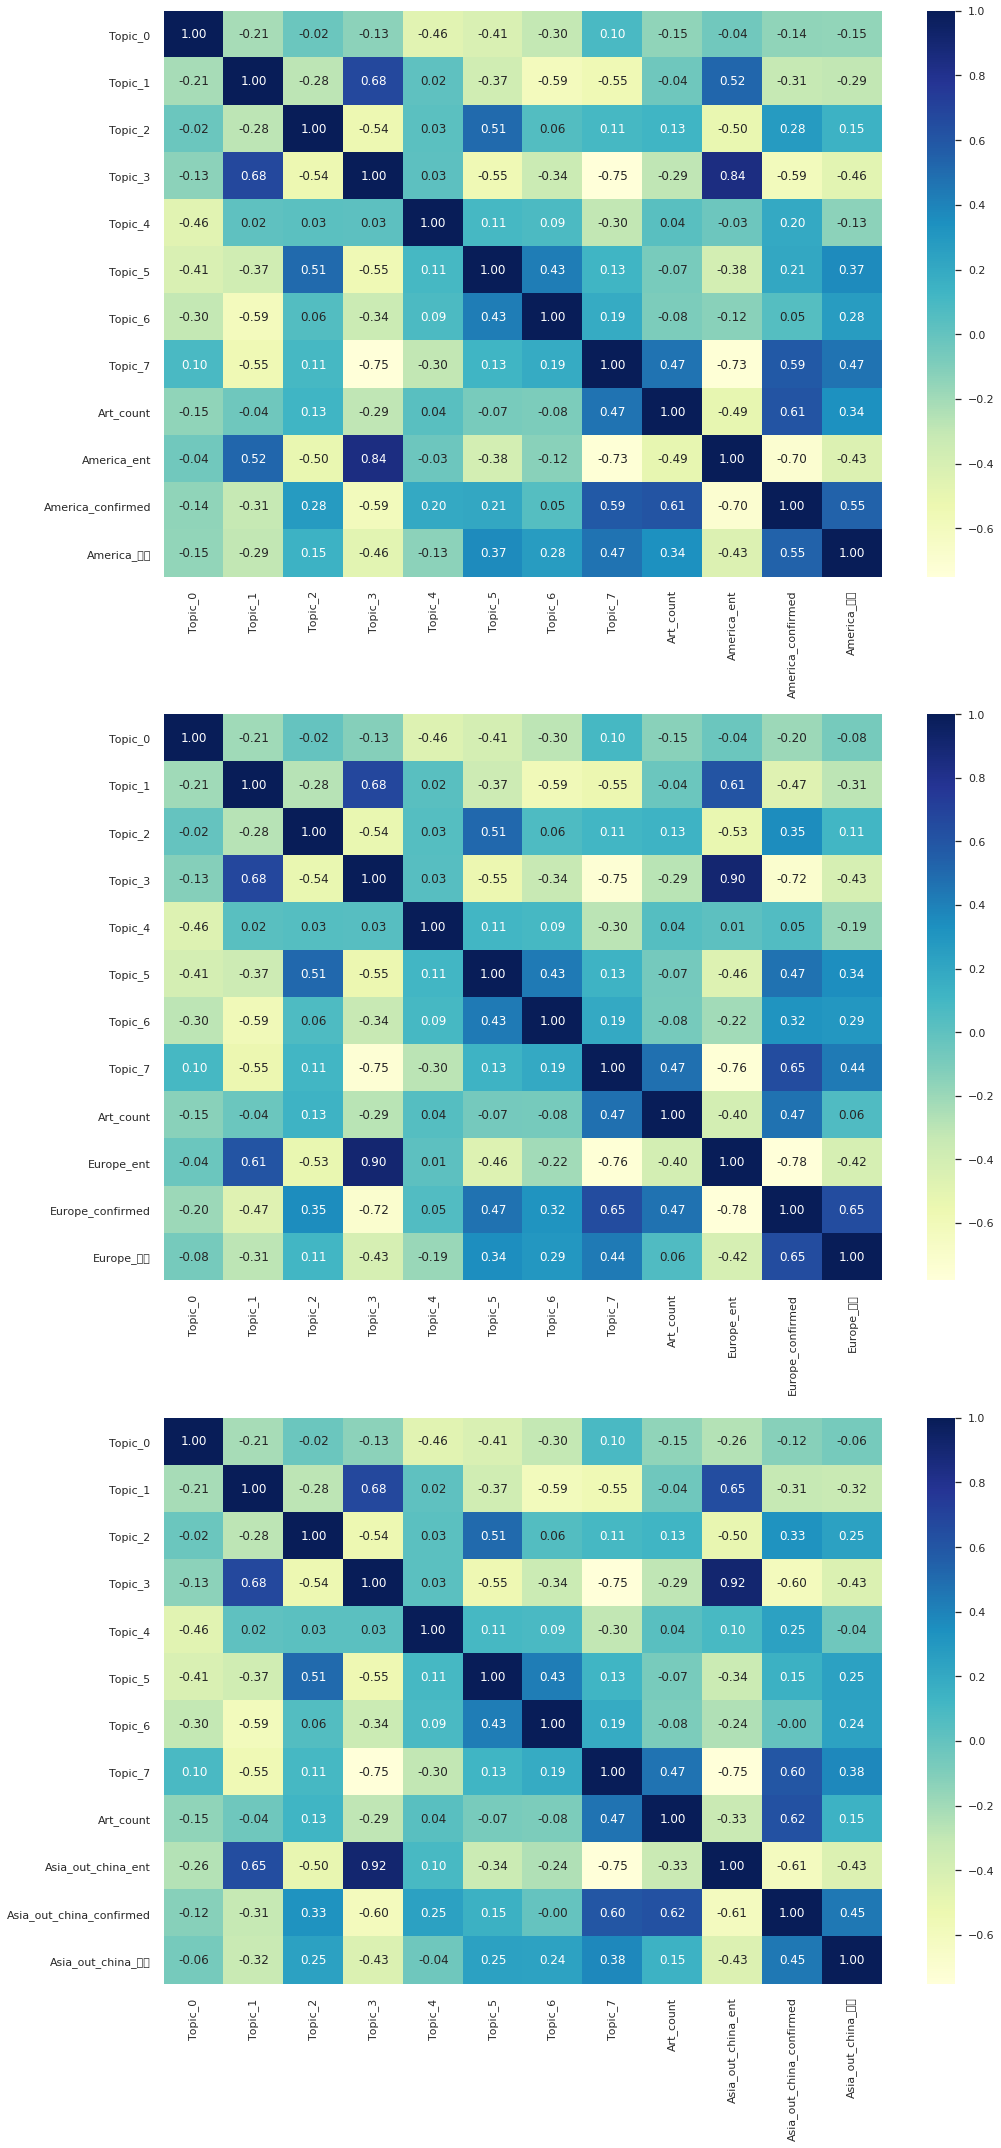

In [178]:
corr_data_america = america.corr()
corr_data_europe = europe.corr()
corr_data_asia = asia.corr()

fig, ax = plt.subplots(3, 1, figsize=(15,30))

sns.heatmap(data=corr_data_america, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax[0])
sns.heatmap(data=corr_data_europe, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax[1])
sns.heatmap(data=corr_data_asia, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax[2])

plt.tight_layout()
plt.show()

## 2. feature 생성

1. lag 1~14인 것 주기.
2. 요일별 특성을 주기.


1. lag: 1~ 14
2. rolling: target

In [136]:
def feature_eng(data_frame):
    
    date = data_frame.iloc[:, 0] # date column
    features = data_frame.iloc[:, 1:-1] # date 제외. target column을 활용한 lag + rolling(mean, std) 포함.
    new_features = pd.DataFrame()
    
    target = data_frame.iloc[:, -1] # target column
    target_rolling = pd.DataFrame()
    
    # 5월 6일 이후의 데이터 생성.
    # test set으로 활용.
    after_may5_date_col = pd.date_range('2020-05-06', periods=14)
    after_may5_input_data = pd.DataFrame(index=after_may5_date_col).reset_index()
    after_may5_input_data.columns = ["Date"]
    
    # lag
    for col_name in features.columns:
        for lag in range(0, 15): # 1~14까지 lag를 바꿔서 특성 추출.
            zero_col_name = col_name + '_lag_0'
            new_col_name = col_name + '_lag_{}'.format(lag)
            new_features[new_col_name] = features[col_name].transform(lambda x: x.shift(lag))
            if lag >= 1:
                after_may5_input_data[new_col_name] = float(new_features[zero_col_name].iloc[-1])
                after_may5_input_data[new_col_name][:lag] = new_features.iloc[:,0][-lag:].values

            else:
                after_may5_input_data[new_col_name] = float(new_features[zero_col_name].iloc[-1])
            
    # target_rolling
    for i in [7, 14]: # 7일과 14일의 평균, 편차를 반영.
        new_col_name_mean = target.name + '_rolling_{}_mean'.format(i)
        new_col_name_std = target.name + '_rolling_{}_std'.format(i)
        target_rolling[new_col_name_mean] = target.rolling(i).mean()
        target_rolling[new_col_name_std] = target.rolling(i).std()
        after_may5_input_data[new_col_name_mean] = target_rolling[new_col_name_mean].iloc[-1]
        after_may5_input_data[new_col_name_std] = target_rolling[new_col_name_std].iloc[-1]
        
    result = pd.concat([date, new_features, target_rolling, target], axis=1)
        
    return result, after_may5_input_data

In [137]:
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()

for name in nation_name:
    train_df, test_df = feature_eng(eval(name))
    
    
    
    if name == 'america':
        train_df = train_df[train_df['Date'] >= '2020-03-09'].reset_index(drop=True)
    elif name == 'africa':
        train_df = train_df[train_df['Date'] >= '2020-03-15'].reset_index(drop=True)
    elif name == 'europe':
        train_df = train_df[train_df['Date'] >= '2020-02-26'].reset_index(drop=True)
    elif name == 'china':
        train_df = train_df[train_df['Date'] >= '2020-01-31'].reset_index(drop=True)
    elif name == 'asia':
        train_df = train_df[train_df['Date'] >= '2020-01-28'].reset_index(drop=True)
    elif name == 'austrailia':
        train_df = train_df[train_df['Date'] >= '2020-03-12'].reset_index(drop=True)
    
    # Topic, target, Date columns를 제외한 나머지를 각각의 column에 대해 min_max scaling. 
    train_scale_df = train_df.iloc[:, 121:-1] # 유입 특성 제외시 -5로 slicing.
    test_scale_df = test_df.iloc[:, 121:] # 유입 특성 제외시 -4로 slicing.
    
    # fit, transform
    min_max.fit(train_scale_df)
    train_scale_df = pd.DataFrame(min_max.transform(train_scale_df), columns=train_scale_df.columns)
    test_scale_df = pd.DataFrame(min_max.transform(test_scale_df), columns=train_scale_df.columns)
    
    # 다시 train_df, test_df에 넣어줌.
    train_df[train_scale_df.columns] = train_scale_df
    test_df[test_scale_df.columns] = test_scale_df
    
    # 각 대륙별로 데이터 프레임 저장.
    
    train_df.to_pickle("./data_processed/Z.Train_test/{}_train.pkl".format(name))
    test_df.to_pickle("./data_processed/Z.Train_test/{}_test.pkl".format(name))